In [1]:
from src import *

Movie name used for gradient: `'TC_400_sub-S09_ses-4_Sintel.csv'`

In [16]:
# Loading Gradient Example
mri_path = "./data/fmri_compile.csv"
mri_df   = pd.read_csv(mri_path)
G_movie  = np.load("./eg_gradient_movie.npy")

# Loading Matching Emotion Track
emo_df = pd.read_csv('./data/emotion_compile.csv')
emo_df = emo_df[emo_df['filename']=='W_Sintel13.csv']

In [17]:
index2region = {}
for R in mri_df.partial_region.unique():
    index2region[R] = mri_df[mri_df['partial_region'] == R].vindex.unique()

Text(0.5, 0.98, 'Movie Gradient 1: region centroids position shift and concentration')

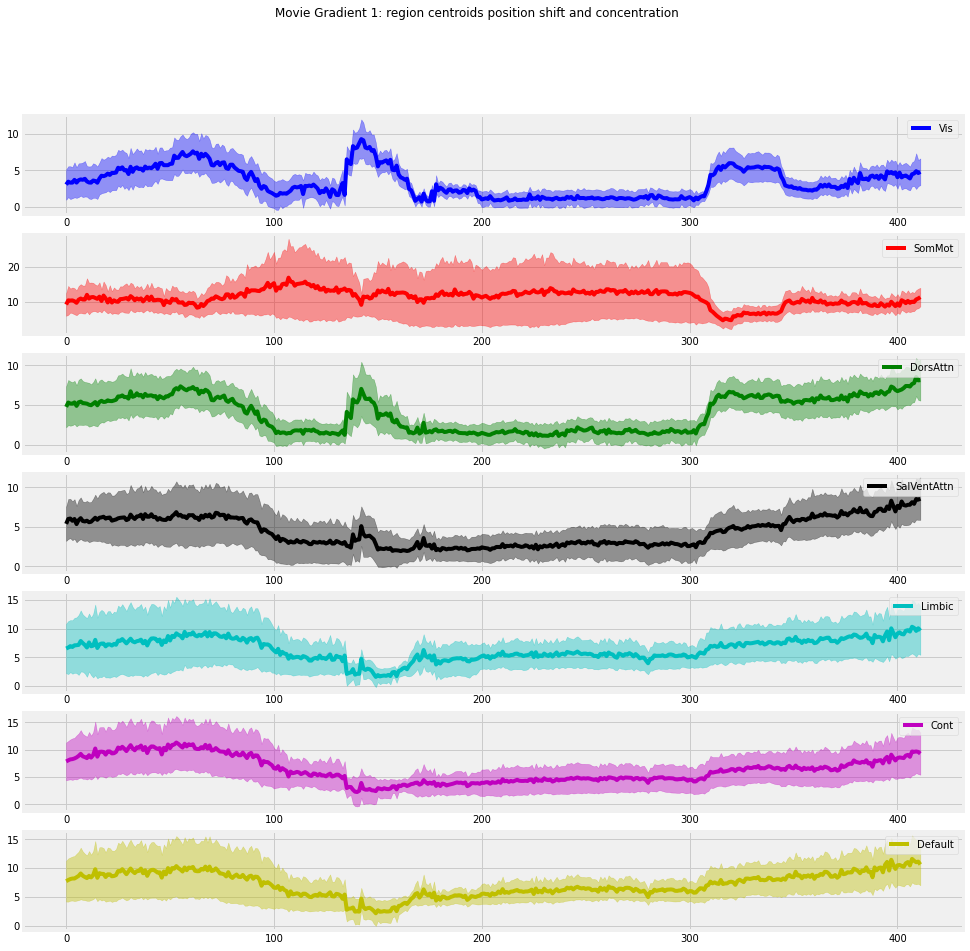

In [19]:
n = len(mri_df.partial_region.unique())
fig, ax = plt.subplots(n,1,figsize=(15,15))
grad_idx = 0
for idx, R in enumerate(mri_df.partial_region.unique()):
    y = np.abs(G_movie[:,index2region[R]]).mean(axis=1)[:,grad_idx]
    x = np.arange(len(y))
    error = np.abs(G_movie[:,index2region[R]]).std(axis=1)[:,grad_idx]

    ax[idx].plot(x,y, color=PALETTE[idx], label=R)
    ax[idx].fill_between(x, y-error, y+error, color=PALETTE[idx], alpha=0.4)
    ax[idx].legend()
    # ax[idx].set_ylim(0, 30)
plt.suptitle("Movie Gradient {}: region centroids position shift and concentration".format(grad_idx + 1))

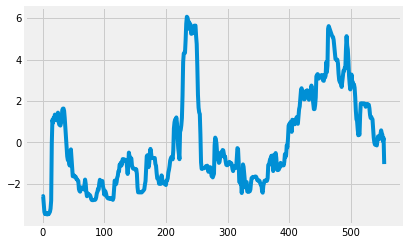

In [20]:
emotion = 'IntenseEmotion'
emo_series = np.array(emo_df[emo_df.item==emotion]['score'])
plt.plot(emo_series)